# Graph-to-Cell Discrete Configuration Complex Lifting Tutorial


---

This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

---

---

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the _dataset_name_ variable in [Dataset config](#dataset-config) to one of the following names:

- cocitation_cora
- cocitation_citeseer
- cocitation_pubmed
- MUTAG
- NCI1
- NCI109
- PROTEINS_TU
- AQSOL
- ZINC

---


### Imports and utilities


In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

## Loading the dataset


Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [2]:
dataset_name = "simple_configuration_graphs"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for simple_configuration_graphs:

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'simple_configuration_graphs',
 'data_dir': 'datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'graph'}


We can then access to the data through the `load()`method:



Dataset contains 3 samples.

Providing more details about sample 0/3:


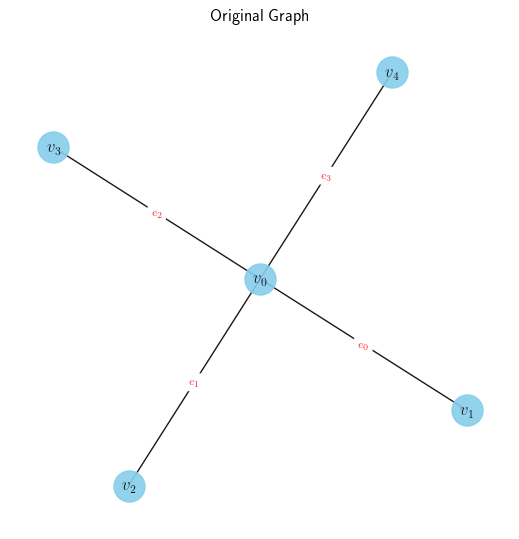

 - Graph with 4 vertices and 4 edges.
 - Features dimensions: [1, 1]
 - There are 0 isolated nodes.



Data(x=[4, 1], edge_index=[2, 4], edge_attr=[4, 1], y=[1], num_nodes=4)

In [3]:
dataset = loader.load()
describe_data(dataset, 0)
dataset.get(2)

## Loading and Applying the Lifting


In this section we will instantiate the lifting we want to apply to the data. For this example the **discrete configuration complex** of a graph was chosen. This was first proposed by Abrams in [1] (see also [2] and [3]), and is an example of a **cubical complex**[4]. While a simplicial complex is built up of points, edges, triangles, tertrahedrons, and so on, a cubical complex is composed of points, edges, squares, cubes, and hypercubes. Another way to think of a cubical complex is that a cell of dimension $n$ is composed of exactly $2n$ 'faces' of dimension $n-1$ (so a square is composed of 4 edges, a cube of 6 squares, and so on).

The **discrete configuration complex** $D_k(G)$ of a graph $G$ is the set of all _legal configurations of k agents_ on edges or vertices of $G$. For a configuration to be legal, each chosen edge or vertex must be unique, and if a given edge is part of a configuration, then neither of its endpoints may also be included. Furthermore, if two edges share an endpoint, then only one can be included. This can also be phrased as 'each agent must be at least 1 edge away from any other agent'. Each configuration is then a cell in the complex, where the dimension of the cell is the number of edges in the configuration (hence the complex has dimension $k$).

One motivation for this construction is motion planning for robotics. In this case, the 'agents' represent individual robots, and the graph represents the possible locations each robot can take and the paths between them. The topology of the configuration complex then encodes how robots can move from one configuration to another in a 'safe' way without collisions. For more details see [1], [2], [3], and [5].

Note that this cell complex is large - it has $O((n + m)^k)$ cells (and has runtime $O((n + m)^k)$), where $n$ is the number of nodes and $m$ is the number of edges in $G$. Therefore it is not recommended to use it for large graphs.

---

[1] A. Abrams and R. Ghrist. Finding topology in a factory: Configuration spaces. Amer. Math. Monthly 109:140–150, 2002.

[2] A. Abrams and R. Ghrist. State complexes for metamorphic robot systems. Int. J. Robotics Research 23(7–8):809–824, 2004.

[3] A. D. Abrams. Configuration Spaces and Braid Groups of Graphs. Ph.D. thesis, Dept. Math., U.C. Berkeley, 2000. [link](http://www.mathcs.emory.edu/~abrams/research/Papers/thesis.ps).

[4] [Wikipedia - Cubical Complex](https://en.wikipedia.org/wiki/Cubical_complex)

[5] Computational Topology (Jeff Erickson) Cell Complexes: Definitions. (n.d.). Available at: [https://jeffe.cs.illinois.edu/teaching/comptop/2009/notes/cell-complex-examples.pdf](https://jeffe.cs.illinois.edu/teaching/comptop/2009/notes/cell-complex-examples.pdf)

---

For cell complexes creating a lifting involves creating a `CellComplex` object from topomodelx and adding cells to it using the method `add_cells_from`. The `CellComplex` class then takes care of creating all the needed matrices.

Similarly to before, we can specify the transformation we want to apply through its type and id --the correxponding config files located at `/configs/transforms`.

Note that the _transform_config_ dictionary generated below can contain a sequence of tranforms if it is needed.

This can also be used to explore liftings from one topological domain to another, for example using two liftings it is possible to achieve a sequence such as: graph -> cell complex -> hypergraph.


In [4]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2cell/discrete_configuration_complex_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for graph2cell/discrete_configuration_complex_lifting:

{'transform_type': 'lifting',
 'transform_name': 'DiscreteConfigurationComplexLifting',
 'k': 2,
 'feature_aggregation': 'concat',
 'preserve_edge_attr': True,
 'feature_lifting': 'ProjectionSum'}


We than apply the transform via our `PreProcesor`. Observe that the lifting does not preserve the original graph! That is because the nodes of the new complex are now **tuples** of $k$ vertices in the original graph. The new lifted complex may have very different topology - it may even be disconnected.


Transform parameters are the same, using existing data_dir: /Users/tlong/Documents/code/challenge-icml-2024/datasets/graph/toy_dataset/simple_configuration_graphs/lifting/3192475844

Dataset contains 3 samples.

Providing more details about sample 0/3:


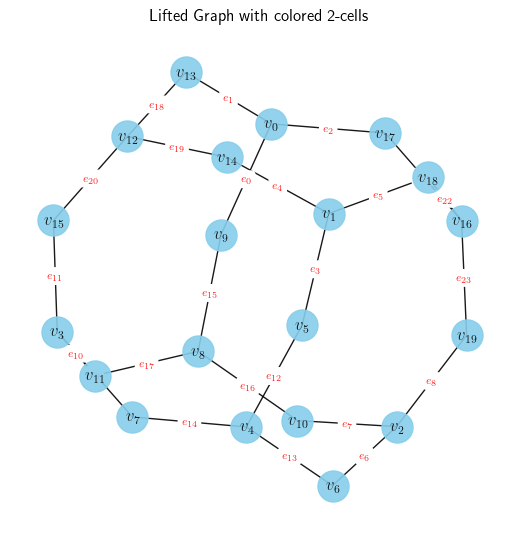

 - Graph with 20 vertices and 24 edges.
 - Features dimensions: [2, 2]


Dataset contains 3 samples.

Providing more details about sample 1/3:


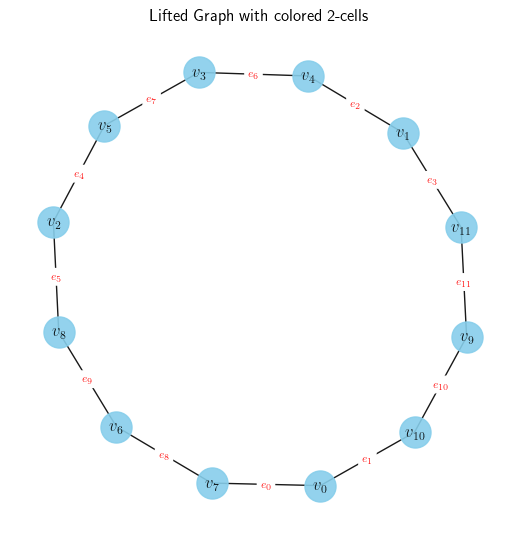

 - Graph with 12 vertices and 12 edges.
 - Features dimensions: [2, 2]


Dataset contains 3 samples.

Providing more details about sample 2/3:


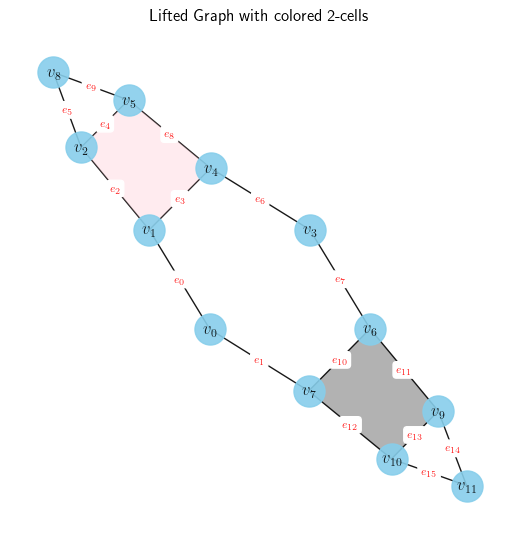

 - The complex has 12 0-cells.
 - The 0-cells have features dimension 2
 - The complex has 16 1-cells.
 - The 1-cells have features dimension 2
 - The complex has 2 2-cells.
 - The 2-cells have features dimension 2



In [5]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)

if dataset_name == "simple_configuration_graphs":
    for i in range(len(lifted_dataset.data_list)):
        describe_data(lifted_dataset, i)
else:
    describe_data(lifted_dataset)

## Create and Run a Cell NN Model


In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `x_0`, `x_1`, `x_2` which are the features of the nodes, edges and cells respectively. It also uses the `adjacency_1`, `incidence_1` and `incidence_2` matrices so the lifting should make sure to add them to the data.


In [6]:
from modules.models.cell.cwn import CWNModel

model_type = "cell"
model_id = "cwn"
model_config = load_model_config(model_type, model_id)

# If we concatenate features in the lifting, they will be larger
if transform_config["lifting"]["feature_aggregation"] == "concat":
    dataset_config["num_features"] *= transform_config["lifting"]["k"]

model = CWNModel(model_config, dataset_config)


Model configuration for cell CWN:

{'in_channels_0': None,
 'in_channels_1': None,
 'in_channels_2': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2}


In [7]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors.
